# Predicting Myers-Briggs Personality Types from Twitter Posts

---

<a id='exploratory-data-analysis'></a>
## Exploratory Data Analysis (EDA)

In [1]:
# Import libraries
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize

import string
from string import punctuation

from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn import model_selection
from sklearn.model_selection import train_test_split

from sklearn import feature_extraction
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier

from sklearn import pipeline
from sklearn.pipeline import make_pipeline

from sklearn import naive_bayes
from sklearn import neural_network
from sklearn import feature_selection


import tensorflow as tf
import os
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [2]:
# Load dataset
df = pd.read_csv('resources/mbti_clean.csv')

<a id='data-dictionary'></a>
**Data Dictionary** 

Variables in original dataframe:
- *type*: (string) four-letter Myers-Briggs Type Index (MBTI) code
- *posts*: (string) text of fifty most recent posts to the *PersonalityCafe* forum

New variables added for analysis in the *df* dataframe:
- *I-E*: (string) code on Introversion-Extroversion axis, derived from *type*
- *N-S*: (string) code on Intuition-Sensing axis, derived from *type*
- *T-F*: (string) code on Thinking-Feeling axis, derived from *type*
- *J-P*: (string) code on Judging-Perceiving axis, derived from *type*

In [3]:
# View first five rows of dataset
df.head()

,type,posts
0,INFJ,The last thing INFJ friend posted his facebo...
1,INFJ,Hello ENFJ Sorry hear your distress Its only...
2,INFJ,Prozac wellbrutin least thirty minutes movin...
3,INFJ,Basically come with three items youve determi...
4,INFJ,All things moderation Sims indeed video ga...


In [4]:
# View shape of dataset
df.shape

(283792, 2)

In [5]:
# View information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283792 entries, 0 to 283791
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   type    283792 non-null  object
 1   posts   283792 non-null  object
dtypes: object(2)
memory usage: 4.3+ MB


The column names are 'type' and 'posts'. Both are datatype 'object'. There are no null values.

In [6]:
# Examine number of unique items are in the 'type' (classification) column
df['type'].unique()

array(['INFJ', 'ENTP', 'INTP', 'INTJ', 'ENTJ', 'ENFJ', 'INFP', 'ENFP',
       'ISFP', 'ISTP', 'ISFJ', 'ISTJ', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ'],
      dtype=object)

The 'type' column contains 16 unique codes, representing the 16 different personality types.

In [7]:
# Explore the counts for each of these types
df['type'].value_counts()

INFP    60583
INFJ    50417
INTP    42071
INTJ    35109
ENFP    22361
ENTP    21922
ISTP    10404
ISFP     8089
ENTJ     7597
ISTJ     6679
ENFJ     6481
ISFJ     5435
ESTP     2697
ESFJ     1441
ESFP     1256
ESTJ     1250
Name: type, dtype: int64

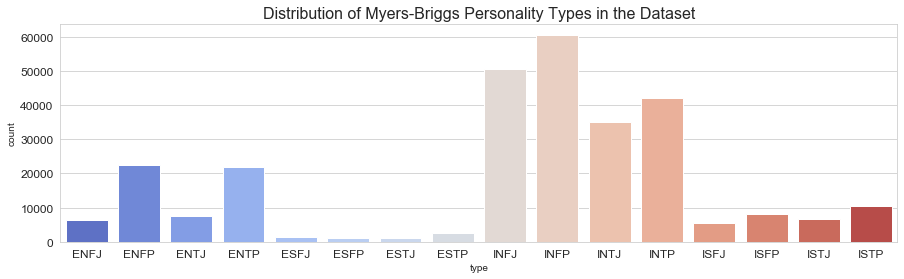

In [8]:
# Countplot of the 16 personality types in the dataset
dims1 = (15.0, 4.0)
fig, ax = plt.subplots(figsize=dims1)
coolwarm = sns.color_palette("coolwarm", 16)
sns.set_palette(coolwarm)
sns.countplot(x="type", data=df, \
              order=["ENFJ","ENFP","ENTJ","ENTP","ESFJ","ESFP","ESTJ","ESTP",\
                     "INFJ","INFP","INTJ","INTP","ISFJ","ISFP","ISTJ","ISTP"])
plt.title("Distribution of Myers-Briggs Personality Types in the Dataset", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

In [9]:
# Explore the counts for each axis of the types
print('Introversion (I) – Extroversion (E)', '\n', df['type'].map(lambda x: x[0]).value_counts(), '\n')
print('Intuition (N) – Sensing (S)', '\n', df['type'].map(lambda x: x[1]).value_counts(), '\n')
print('Thinking (T) – Feeling (F)', '\n', df['type'].map(lambda x: x[2]).value_counts(), '\n')
print('Judging (J) – Perceiving (P)', '\n', df['type'].map(lambda x: x[3]).value_counts(), '\n')

Introversion (I) – Extroversion (E) 
 I    218787
E     65005
Name: type, dtype: int64 

Intuition (N) – Sensing (S) 
 N    246541
S     37251
Name: type, dtype: int64 

Thinking (T) – Feeling (F) 
 F    156063
T    127729
Name: type, dtype: int64 

Judging (J) – Perceiving (P) 
 P    169383
J    114409
Name: type, dtype: int64 



The dataset contains many more Introverts (I) than Extroverts (E), and more Intuitives (N) than Sensers (S). The distributions of Thinkers (T) vs. Feelers (F), and Judgers (J) vs. Perceivers (P) are more balanced.

---

<a id='preprocessing'></a>
## Preprocessing

In [10]:
# Create a working copy of the dataframe
df_working = df.copy()
df_working.head()

,type,posts
0,INFJ,The last thing INFJ friend posted his facebo...
1,INFJ,Hello ENFJ Sorry hear your distress Its only...
2,INFJ,Prozac wellbrutin least thirty minutes movin...
3,INFJ,Basically come with three items youve determi...
4,INFJ,All things moderation Sims indeed video ga...


In [11]:
# Create a binary column for each of the 4 axis types for later analysis
df_working['I-E'] = df_working['type'].map(lambda x: 'Introversion' if x[0] == 'I' else 'Extroversion')
df_working['N-S'] = df_working['type'].map(lambda x: 'Intuition' if x[1] == 'N' else 'Sensing')
df_working['T-F'] = df_working['type'].map(lambda x: 'Thinking' if x[2] == 'T' else 'Feeling')
df_working['J-P'] = df_working['type'].map(lambda x: 'Judging' if x[3] == 'J' else 'Perceiving')

df_working.head()

,type,posts,I-E,N-S,T-F,J-P
0,INFJ,The last thing INFJ friend posted his facebo...,Introversion,Intuition,Feeling,Judging
1,INFJ,Hello ENFJ Sorry hear your distress Its only...,Introversion,Intuition,Feeling,Judging
2,INFJ,Prozac wellbrutin least thirty minutes movin...,Introversion,Intuition,Feeling,Judging
3,INFJ,Basically come with three items youve determi...,Introversion,Intuition,Feeling,Judging
4,INFJ,All things moderation Sims indeed video ga...,Introversion,Intuition,Feeling,Judging


Codes for the new columns:
- I-E: Introversion - Extroversion
- N-S: Intuition - Sensing
- T-F: Thinking - Feeling
- J-P: Judging - Perceiving

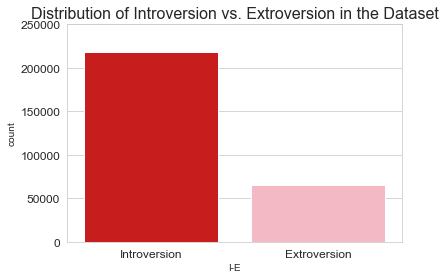

In [12]:
# Plot of Introversion - Extroversion axis
IEcolors = sns.xkcd_palette(["red", "soft pink"])
sns.set_palette(IEcolors)
sns.countplot(x="I-E", data=df_working, order=["Introversion", "Extroversion"])
plt.title("Distribution of Introversion vs. Extroversion in the Dataset", fontsize=16)
plt.ylim(0, 250000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar chart above show that the dataset is heavily skewed toward Introversion over Extroversion.

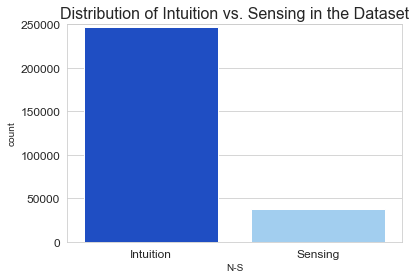

In [13]:
# Plot of Intuition - Sensing axis
NScolors = sns.xkcd_palette(["blue", "light blue"])
sns.set_palette(NScolors)
sns.countplot(x="N-S", data=df_working, order=["Intuition", "Sensing"])
plt.title("Distribution of Intuition vs. Sensing in the Dataset", fontsize=16)
plt.ylim(0, 250000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar chart above shows that the dataset is heavily skewed toward Intuition over Sensing.

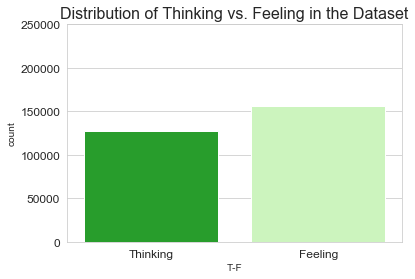

In [14]:
# Plot of Thinking - Feeling axis
TFcolors = sns.xkcd_palette(["green", "pale green"])
sns.set_palette(TFcolors)
sns.countplot(x="T-F", data=df_working, order=["Thinking", "Feeling"])
plt.title("Distribution of Thinking vs. Feeling in the Dataset", fontsize=16)
plt.ylim(0, 250000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar chart above shows that the dataset is somewhat skewed toward Feeling over Thinking.

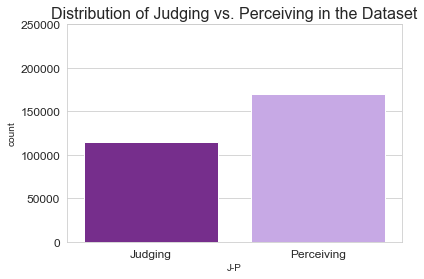

In [15]:
# Plot of Judging - Perceiving axis
JPcolors = sns.xkcd_palette(["purple", "lavender"])
sns.set_palette(JPcolors)
sns.countplot(x="J-P", data=df_working, order=["Judging", "Perceiving"])
plt.title("Distribution of Judging vs. Perceiving in the Dataset", fontsize=16)
plt.ylim(0, 250000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

The bar chart above shows that the dataset is moderately skewed toward Perceiving over Judging.

In [16]:
# Subset the posts column for further exploration
posts = df['posts'].str.lower()

#### Word count

In [17]:
# Create the stopwords list
stoplist = stopwords.words('english') + list(punctuation)

# Add to the stopwords list each of the 16 codes
types = ['infj', 'entp', 'intp', 'intj', 'entj', 'enfj', 'infp', 'enfp', 'isfp', \
         'istp', 'isfj', 'istj', 'estp', 'esfp', 'estj', 'esfj', 'facebook']

for type in types:
    stoplist.append(type)
    

# Create empty list where individual words will be saved
words = [] 

# Split the words from each posts (tweet)
for w in posts:
    tweet = w.split()
    # Remove stop words from tweet 
    for word in tweet:
        if not word in stoplist: 
            words.append(word)

# Create a collection (word counter)
word_count = Counter(word_tokenize('\n'.join(words)))

# Create empty lists word_top_25 and freq_top_25
words_top_25 = []
freq_top_25 = []

print("\nMost frequent words with counts:")

# Find and print the most common words (top 25)
for word, frequency in word_count.most_common(25):
    print('%s: %d' % (word, frequency))
    words_top_25.append(word)
    freq_top_25.append(frequency)
print("\n")


Most frequent words with counts:
like: 60784
dont: 47647
think: 44665
people: 43085
know: 32985
really: 31821
one: 31603
would: 30973
get: 27596
ive: 27445
time: 24347
feel: 21142
much: 20473
well: 19531
things: 19089
say: 17957
something: 17696
way: 17685
good: 17443
want: 17245
see: 16926
love: 16820
also: 16617
even: 15406
always: 15177




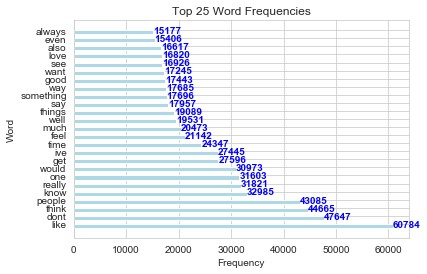

In [18]:
# Plot the counts of the 25 most frequent words
# Horizontal Boxplots
fig, ax = plt.subplots()
width = 0.5
ind = np.arange(len(words_top_25))
ax.barh(ind, freq_top_25, width, color = 'lightblue')
ax.set_yticks(ind + width / 2)
ax.set_yticklabels(words_top_25, minor = False)
for i, v in enumerate(freq_top_25):
    ax.text(v + 2, i - 0.125, str(v), color = 'blue', fontweight = 'bold')
plt.title('Top 25 Word Frequencies')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

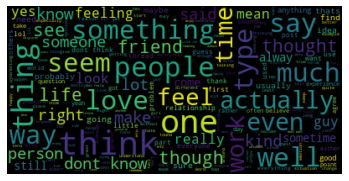

In [19]:
# Wordcloud Why not??
from wordcloud import WordCloud
from os import path

wordcloud_words = " ".join(words)
# Lower max font size
wordcloud = WordCloud(max_font_size = 40).generate(wordcloud_words)
plt.figure()
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

---

<a id='classification'></a>
## Classification

<a id='multiclass-classification'></a>
### Multiclass classification (16 classes)

##### Baseline calculation

A baseline is a fixed point of reference that is used for comparison purposes.

Predicting "INFP" *(most frequent type)* every time.

The accuracy will be the number of entries of "INFP" divided by the total number of entries of all personality types.

In [20]:
# Determine baseline
print("The count for the most frequent type (INFP) is: ", df['type'].value_counts().max())


print("The total count of personality type entries is: ", df['type'].value_counts().sum())


baseline = df['type'].value_counts().max() / df['type'].value_counts().sum()
print(f"The baseline is: {df['type'].value_counts().max() / df['type'].value_counts().sum(): .3f}")

The count for the most frequent type (INFP) is:  60583
The total count of personality type entries is:  283792
The baseline is:  0.213


##### Train-test split

In [21]:
# Train-test split, using type variable as target and posts variable as predictor
X_train, X_test, y_train, y_test = train_test_split(df['posts'].values,
                                                   df[['type']].values,
                                                   test_size=0.30, random_state=42)

print("X_train: ", len(X_train))
print("-----------------")
print("X_test: ", len(X_test)) 
print("-----------------")
print("y_train: ", len(y_train))
print("-----------------")
print("y_test: ", len(y_test))
print("-----------------")



X_train:  198654
-----------------
X_test:  85138
-----------------
y_train:  198654
-----------------
y_test:  85138
-----------------


##### Truncated SVD

*TruncatedSVD* is a variant of principal component analysis (pca) used on sparse matrices to reduce dimensionality

In [22]:
# Run CountVectorizer on the X train/test ('posts' column)
cv = CountVectorizer(stop_words=stoplist, ngram_range=(1,2), max_features=1000)
cv.fit(X_train)
X_train_cv = cv.transform(X_train)

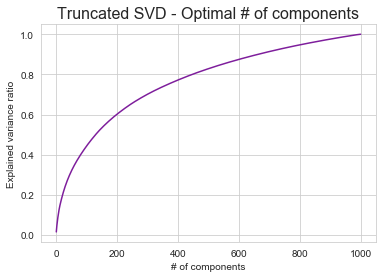

In [23]:
# Run Truncated SVD
# First use max components and graph the explained variance ratio to find cutoff point 
tsvd = TruncatedSVD(n_components=999)
tsvd.fit(X_train_cv)
plt.plot(range(999), tsvd.explained_variance_ratio_.cumsum())
plt.title("Truncated SVD - Optimal # of components", fontsize=16)
plt.xlabel("# of components")
plt.ylabel("Explained variance ratio");

The graph above suggests that approximately 200 components would be most effective, since it is where the explained variance begins to flatten out.

In [24]:
# Run a Truncated SVD with 200 components
tsvd = TruncatedSVD(n_components=200)
tsvd.fit(X_train_cv)
X_train_tsvd = tsvd.transform(X_train_cv)

X_test_cv = cv.transform(X_test)
X_test_tsvd = tsvd.transform(X_test_cv)

**Preprocessing Pipeline**

In [25]:
# Pipeline for the data preprocessing steps (CountVectorizer, TruncatedSVD) on the X data
pipeline_preprocessing = make_pipeline(
    CountVectorizer(stop_words=stoplist, ngram_range=(1,2), max_features=1000),
    TruncatedSVD(n_components=200))

X_train_tsvd = pipeline_preprocessing.fit_transform(X_train)
X_test_tsvd = pipeline_preprocessing.transform(X_test)

<a id='modeling'></a>
### Modeling

<a id='random-forest-classifier'></a>
#### Model: Random Forest Classifier

*RandomForestClassifier* is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and use averaging to improve the predictive accuracy and control over-fitting.

In [26]:
# Create a random forest classifier.
rfc = RandomForestClassifier(n_estimators=30, random_state=123)

# Fitting the model
rfc = rfc.fit(X_train_tsvd, y_train)

# Evaluate the model
y_pred = rfc.predict(X_test_tsvd)
print(f"Random forest predictive accuracy: {accuracy_score(y_test,y_pred):.3f}")
print("____________________________________________________")
print("Classification Report:")
print(classification_report(y_test, y_pred))

C:\Users\quija\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


Random forest predictive accuracy: 0.196
____________________________________________________
Classification Report:
              precision    recall  f1-score   support

        ENFJ       0.20      0.01      0.01      1968
        ENFP       0.10      0.04      0.05      6749
        ENTJ       0.23      0.01      0.02      2223
        ENTP       0.09      0.03      0.05      6577
        ESFJ       0.80      0.01      0.02       448
        ESFP       0.75      0.01      0.02       374
        ESTJ       0.25      0.00      0.00       410
        ESTP       0.60      0.01      0.03       801
        INFJ       0.19      0.33      0.24     15074
        INFP       0.23      0.46      0.31     18285
        INTJ       0.15      0.09      0.11     10587
        INTP       0.17      0.15      0.16     12631
        ISFJ       0.08      0.00      0.00      1593
        ISFP       0.48      0.01      0.02      2428
        ISTJ       0.34      0.01      0.01      1945
        ISTP      

In [27]:
# Make confusion matrix and covert it to a dataframe to prepare it for heatmapping
cm_rfc = np.array(confusion_matrix(y_test, rfc.predict(X_test_tsvd)))

cm_randomforest = pd.DataFrame(cm_rfc, index=['ENFJ', 'ENFP', 'ENTJ', 'ENTP', 'ESFJ', 'ESFP',
                                       'ESTJ', 'ESTP', 'INFJ', 'INFP', 'INTJ', 'INTP',
                                       'ISFJ', 'ISFP', 'ISTJ', 'ISTP'], 
                            columns=['predict_ENFJ','predict_ENFP','predict_ENTJ',
                                     'predict_ENTP','predict_ESFJ','predict_ESFP',
                                     'predict_ESTJ','predict_ESTP','predict_INFJ',
                                     'predict_INFP','predict_INTJ','predict_INTP',
                                     'predict_ISFJ','predict_ISFP','predict_ISTJ',
                                     'predict_ISTP'])

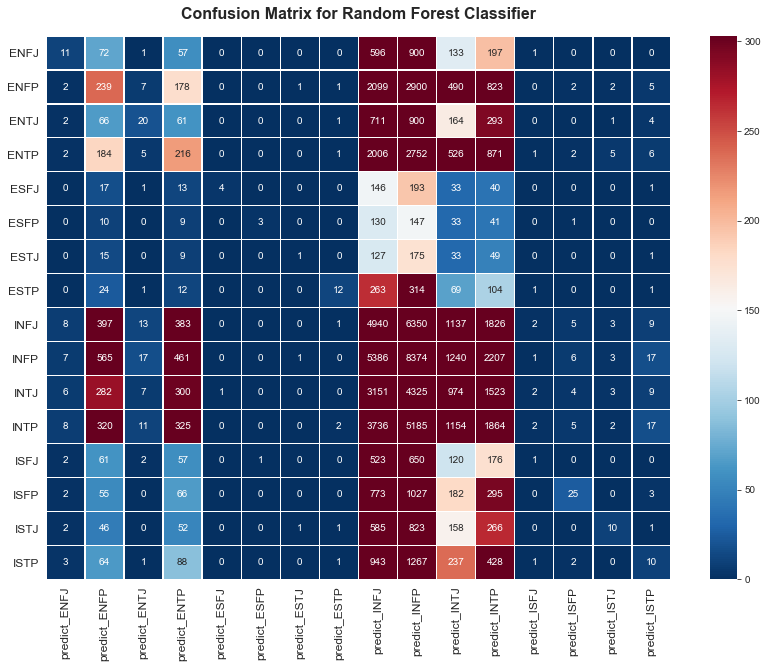

In [28]:
# Create confusion matrix heatmap of Random Forest Classifier model 
fig, ax = plt.subplots(figsize=(14,10)) 
plt.title('Confusion Matrix for Random Forest Classifier', fontsize=16,
          fontweight='bold', y=1.02)
sns.heatmap(cm_randomforest, robust=True, annot=True, linewidth=0.5, 
            fmt='', cmap='RdBu_r', vmax=303, ax=ax)
plt.xticks(fontsize=12)
plt.yticks(rotation=0, fontsize=12);

In the heatmapped confusion matrix above, it is clear that the Random Forest Classifier model is making predictions mostly within six of the sixteen classes:
INFJ, INFP, INTJ, INTP, ENFP, and ENTP.
The other ten categories receive very low predictions or no predictions from this model at all. This model accuracy has a slightly lower accuracy than the baseline and it is not suited to predicting classes outside of the ones with the highest frequency.

<a id='neural-network-classifier'></a>
#### Model: Neural Network

An artificial *neural network* is a computational nonlinear model based on the neural structure of the brain that is able to learn to perform tasks like classification, prediction, decision-making, visualization, and others just by considering examples.

In [29]:
# Scale the training and testing input features using StandardScaler
X_scaler = StandardScaler()
X_scaler.fit(X_train_tsvd)

X_train_scaled = X_scaler.transform(X_train_tsvd)
X_test_scaled = X_scaler.transform(X_test_tsvd)

In [30]:
# Apply One-hot encoding to the target labels
enc = OneHotEncoder() 
enc.fit(y_train)

encoded_y_train = enc.transform(y_train).toarray()
encoded_y_test = enc.transform(y_test).toarray()
encoded_y_train[0]
encoded_y_test[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [31]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = X_train_scaled.shape[1]
hidden_nodes_layer1 =  80
hidden_nodes_layer2 = 30


nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(
    tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu")
)

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))



# Output layer
nn.add(tf.keras.layers.Dense(units=16, activation="sigmoid"))

# Compile the Sequential model together and customize metrics
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


# Define the checkpoint path and filenames
os.makedirs("Optimization_Checkpoints/checkpoints3/",exist_ok=True)
checkpoint_path = "Optimization_Checkpoints/checkpoints3/weights.{epoch:02d}.hdf5"

# Create a callback that saves the model's weights 
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=1,
    save_weights_only=True,
    save_freq=4020)

# Train the model
fit_model = nn.fit(X_train_scaled, encoded_y_train, epochs=100, callbacks=[cp_callback])

Epoch 1/100
4000/6208 [==================>...........] - ETA: 2s - loss: 0.2325 - accuracy: 0.1931
Epoch 00001: saving model to Optimization_Checkpoints/checkpoints3\weights.01.hdf5
6208/6208 [==============================] - 8s 1ms/step - loss: 0.2230 - accuracy: 0.1988
Epoch 2/100
1804/6208 [=======>......................] - ETA: 5s - loss: 0.1985 - accuracy: 0.2245
Epoch 00002: saving model to Optimization_Checkpoints/checkpoints3\weights.02.hdf5
5817/6208 [===========================>..] - ETA: 0s - loss: 0.1984 - accuracy: 0.2233
Epoch 00002: saving model to Optimization_Checkpoints/checkpoints3\weights.02.hdf5
6208/6208 [==============================] - 8s 1ms/step - loss: 0.1984 - accuracy: 0.2233
Epoch 3/100
3663/6208 [================>.............] - ETA: 3s - loss: 0.1974 - accuracy: 0.2265
Epoch 00003: saving model to Optimization_Checkpoints/checkpoints3\weights.03.hdf5
6208/6208 [==============================] - 8s 1ms/step - loss: 0.1974 - accuracy: 0.2266
Epoch 4/100

6208/6208 [==============================] - 8s 1ms/step - loss: 0.1927 - accuracy: 0.2610
Epoch 24/100
1921/6208 [========>.....................] - ETA: 5s - loss: 0.1920 - accuracy: 0.2642
Epoch 00024: saving model to Optimization_Checkpoints/checkpoints3\weights.24.hdf5
5942/6208 [===========================>..] - ETA: 0s - loss: 0.1925 - accuracy: 0.2623
Epoch 00024: saving model to Optimization_Checkpoints/checkpoints3\weights.24.hdf5
6208/6208 [==============================] - 8s 1ms/step - loss: 0.1925 - accuracy: 0.2622
Epoch 25/100
3738/6208 [=================>............] - ETA: 3s - loss: 0.1925 - accuracy: 0.2638
Epoch 00025: saving model to Optimization_Checkpoints/checkpoints3\weights.25.hdf5
6208/6208 [==============================] - 8s 1ms/step - loss: 0.1926 - accuracy: 0.2626
Epoch 26/100
1570/6208 [======>.......................] - ETA: 5s - loss: 0.1923 - accuracy: 0.2649
Epoch 00026: saving model to Optimization_Checkpoints/checkpoints3\weights.26.hdf5
5591/620

2026/6208 [========>.....................] - ETA: 5s - loss: 0.1916 - accuracy: 0.2707
Epoch 00046: saving model to Optimization_Checkpoints/checkpoints3\weights.46.hdf5
6033/6208 [============================>.] - ETA: 0s - loss: 0.1917 - accuracy: 0.2692
Epoch 00046: saving model to Optimization_Checkpoints/checkpoints3\weights.46.hdf5
6208/6208 [==============================] - 8s 1ms/step - loss: 0.1918 - accuracy: 0.2691
Epoch 47/100
3871/6208 [=================>............] - ETA: 3s - loss: 0.1914 - accuracy: 0.2706
Epoch 00047: saving model to Optimization_Checkpoints/checkpoints3\weights.47.hdf5
6208/6208 [==============================] - 8s 1ms/step - loss: 0.1915 - accuracy: 0.2698
Epoch 48/100
1679/6208 [=======>......................] - ETA: 5s - loss: 0.1916 - accuracy: 0.2689
Epoch 00048: saving model to Optimization_Checkpoints/checkpoints3\weights.48.hdf5
5679/6208 [==========================>...] - ETA: 0s - loss: 0.1916 - accuracy: 0.2685
Epoch 00048: saving model

6129/6208 [============================>.] - ETA: 0s - loss: 0.1910 - accuracy: 0.2736
Epoch 00068: saving model to Optimization_Checkpoints/checkpoints3\weights.68.hdf5
6208/6208 [==============================] - 8s 1ms/step - loss: 0.1910 - accuracy: 0.2735
Epoch 69/100
3947/6208 [==================>...........] - ETA: 2s - loss: 0.1910 - accuracy: 0.2730
Epoch 00069: saving model to Optimization_Checkpoints/checkpoints3\weights.69.hdf5
6208/6208 [==============================] - 8s 1ms/step - loss: 0.1912 - accuracy: 0.2716
Epoch 70/100
1761/6208 [=======>......................] - ETA: 5s - loss: 0.1911 - accuracy: 0.2737
Epoch 00070: saving model to Optimization_Checkpoints/checkpoints3\weights.70.hdf5
5798/6208 [===========================>..] - ETA: 0s - loss: 0.1912 - accuracy: 0.2720
Epoch 00070: saving model to Optimization_Checkpoints/checkpoints3\weights.70.hdf5
6208/6208 [==============================] - 8s 1ms/step - loss: 0.1912 - accuracy: 0.2719
Epoch 71/100
3587/620

  38/6208 [..............................] - ETA: 8s - loss: 0.1925 - accuracy: 0.2784
Epoch 00091: saving model to Optimization_Checkpoints/checkpoints3\weights.91.hdf5
4058/6208 [==================>...........] - ETA: 2s - loss: 0.1906 - accuracy: 0.2754
Epoch 00091: saving model to Optimization_Checkpoints/checkpoints3\weights.91.hdf5
6208/6208 [==============================] - 8s 1ms/step - loss: 0.1908 - accuracy: 0.2744
Epoch 92/100
1862/6208 [=======>......................] - ETA: 5s - loss: 0.1911 - accuracy: 0.2722
Epoch 00092: saving model to Optimization_Checkpoints/checkpoints3\weights.92.hdf5
5887/6208 [===========================>..] - ETA: 0s - loss: 0.1910 - accuracy: 0.2722
Epoch 00092: saving model to Optimization_Checkpoints/checkpoints3\weights.92.hdf5
6208/6208 [==============================] - 8s 1ms/step - loss: 0.1910 - accuracy: 0.2722
Epoch 93/100
3714/6208 [================>.............] - ETA: 3s - loss: 0.1907 - accuracy: 0.2720
Epoch 00093: saving model

In [32]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_train_scaled, encoded_y_train,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")
print(f"Neural Network model accuracy: {model_accuracy:.3f}")

6208/6208 - 4s - loss: 0.1901 - accuracy: 0.2767
Loss: 0.19009362161159515, Accuracy: 0.2767374515533447
Neural Network model accuracy: 0.277
